# Optimization with turbine specific boundaries

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/turbine_specific_boundaries.ipynb) (requires google account)

In this notebook it is demonstrated how to optimize a site with different turbines, where each turbine model has a specific set of constraints associated to it based on the geometry of the turbine. It could be e.g. that there is a specific requirement to how close to a residential area, river or road turbine placement is allowed which could be based on turbine hub height, tip height etc.

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [2]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from py_wake import BastankhahGaussian
from py_wake.utils.gradients import autograd
import topfarm
from topfarm.constraint_components.boundary import TurbineSpecificBoundaryComp, InclusionZone, ExclusionZone
from topfarm import TopFarmListRecorder
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_turbines.power_ct_functions import CubePowerSimpleCt
from shapely.geometry import Polygon, LineString
from py_wake.examples.data.hornsrev1 import Hornsrev1Site

## Wind turbine
Uses the PyWake WindTurbines object

In [3]:
wts = WindTurbines(names=['tb1', 'tb2'],
                   diameters=[80, 120],
                   hub_heights=[70, 110],
                   powerCtFunctions=[
                       CubePowerSimpleCt(ws_cutin=3, ws_cutout=25, ws_rated=12,
                                         power_rated=2000, power_unit='kW',
                                         ct=8 / 9, additional_models=[]),
                       CubePowerSimpleCt(ws_cutin=3, ws_cutout=25, ws_rated=12,
                                         power_rated=3000, power_unit='kW',
                                         ct=8 / 9, additional_models=[]),])

## Turbine specific boundaries
Boundaries can be based on multiplier of turbine diameter or hub-height. It creates "layers" of allowable regions for the different turbine types. Types can be mixed thoughout the farm and the constraint component can be used for descrete turbine type optimization.

Boundaries can be polygons as previously and also lines which then will be extruded based on the turbine geometry. Polygons already extruded from a line with a given buffer, b_ref can also be passed along with this reference value.


In [4]:
# Inclusion zone
b1 = np.transpose(([0, 3000, 3000, 0], [0, 0, 3000, 3000]))

# Buildings
b2 = np.transpose(([600, 1400, 1400, 600], [1700, 1700, 2500, 2500]))

# River
b3 = np.transpose((np.linspace(520, 2420, 16), [   0,  133,  266,  400,  500,  600,  700,  733, 866, 1300, 1633,
       2100, 2400, 2533, 2700, 3000]))

# Road
b4 = np.transpose((np.linspace(0, 3000, 16), [1095, 1038, 1110, 1006, 1028,  992,  977, 1052, 1076, 1064, 1073,
       1027,  964,  981, 1015, 1058]))

zones = [
    InclusionZone(b1, name='i1'),
    ExclusionZone(b2, dist2wt=lambda H: 4 * H - 360, name='building'),
    ExclusionZone(b3, geometry_type='line', dist2wt=lambda D: 3 * D, name='river'),
    ExclusionZone(b4, geometry_type='line', dist2wt=lambda D, H: max(D * 2, H * 3), name='road'),
]


## Include in optimization problem

In [5]:
x_min, x_max = 0, 3000
y_min, y_max = 0, 3000
wfm = BastankhahGaussian(Hornsrev1Site(), wts)
wt_x, wt_y = np.meshgrid(np.linspace(1000, 2500, 4), 
                            np.linspace(500, 1500, 4))
wt_x = wt_x.ravel()
wt_y = wt_y.ravel()
n_wt = len(wt_x)

xybound = XYBoundaryConstraint(zones, turbines=wts, boundary_type='turbine_specific')

t = 0
types = t * np.ones(n_wt)
def aep_func(x, y):
    simres = wfm(x, y, type=types)
    aep = simres.aep(normalize_probabilities=True).values.sum()
    return aep

def dAEPdxy(**kwargs):
    return wfm.aep_gradients(gradient_method=autograd, wrt_arg=['x', 'y'], n_cpu=None, **kwargs)

def daep(**kwargs):
    return dAEPdxy(x=kwargs[topfarm.x_key],
                    y=kwargs[topfarm.y_key])

cost_comp = CostModelComponent(input_keys=[('x', wt_x),('y', wt_y)],
                                          n_wt=len(wt_y),
                                          cost_function=aep_func,
                                          cost_gradient_function=daep,
                                          objective=True,
                                          maximize=True,
                                          output_keys=[('AEP', 0)]
                                          )
problem = TopFarmProblem(design_vars={'x': (wt_x, x_min+1, x_max-1),
                                      'y': (wt_y, y_min+1, y_max-1)},
                        constraints=[xybound, SpacingConstraint(240)],
                        cost_comp=cost_comp,
                        driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=50),
                        plot_comp=XYPlotComp(),
                        expected_cost=1e-4)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


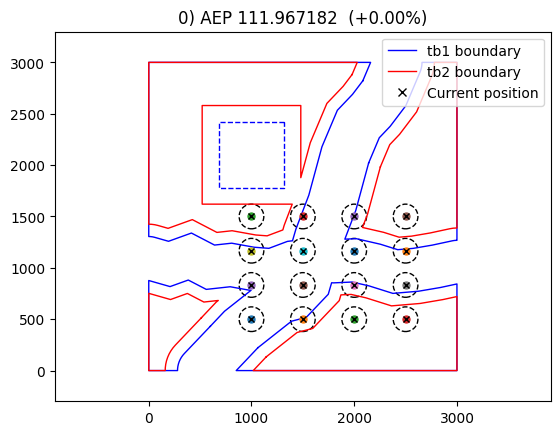

Iteration limit reached    (Exit mode 9)
            Current function value: -1239264.4199488729
            Iterations: 50
            Function evaluations: 51
            Gradient evaluations: 50
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	38.877s


In [6]:
cost, state, recorder = problem.optimize(disp=True)

(-150.0, 3150.0, -150.0, 3150.0)

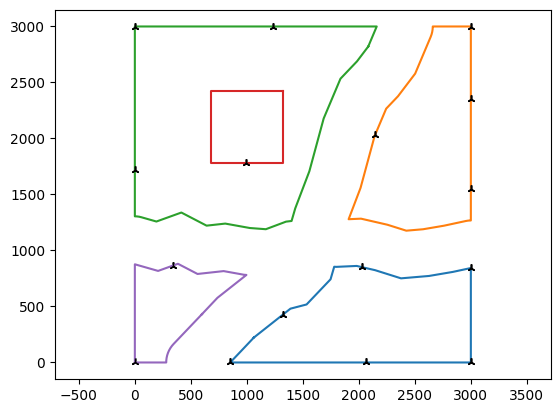

In [9]:
ts_bounds = problem.model.constraint_group.xy_bound_comp.ts_merged_xy_boundaries[t]
plt.figure()
for b, _ in ts_bounds:
    plt.plot(np.append(b[:,0], b[0,0]), np.append(b[:,1], b[0,1]))
    plt.plot(state['x'], state['y'], '2k')
plt.axis('equal')